In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
filename = 'jena_climate_2009_2016.csv'
f = open(filename)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

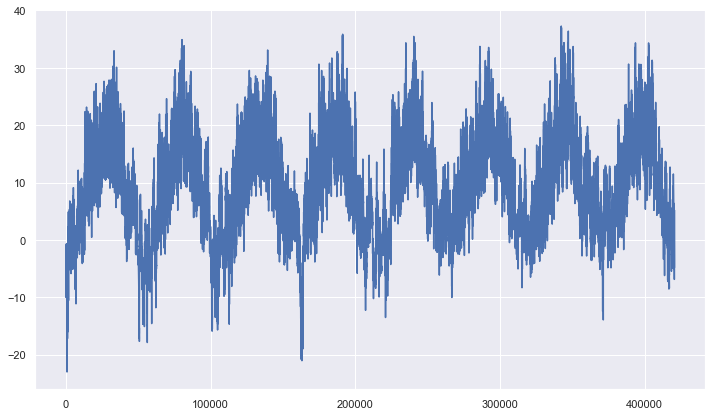

In [5]:
temp = float_data[:, 1]
plt.figure(figsize=(12,7))
plt.plot(range(len(temp)), temp);

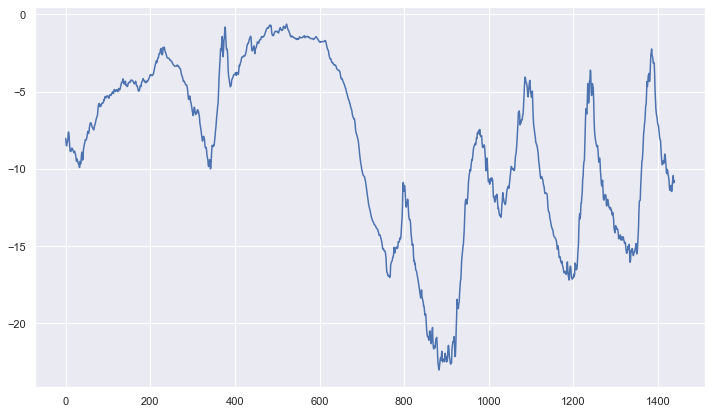

In [6]:
plt.figure(figsize=(12,7))
plt.plot(range(1440), temp[:1440]);

In [7]:
lockback = 720
step = 6
delay = 144

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets           

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)


val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size
#np.mean(np.abs(preds - targets))

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in np.arange(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [12]:
evaluate_naive_method()

0.2897359729905486


In [13]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

W0818 12:58:47.132196 11744 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 12:58:47.165195 11744 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 12:58:47.188284 11744 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [14]:
model.compile(optimizer=RMSprop(), loss='mae')

W0818 12:58:47.220306 11744 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [15]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0818 12:58:47.322391 11744 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0818 12:58:47.326391 11744 deprecation_wrapper.py:119] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 14s 29ms/step - loss: 1.2820 - val_loss: 0.6425
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.4150 - val_loss: 0.3258
Epoch 3/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2892 - val_loss: 0.3124
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2669 - val_loss: 0.3108
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2529 - val_loss: 0.3365
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2459 - val_loss: 0.3194
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2396 - val_loss: 0.3349
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2327 - val_loss: 0.3842
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2292 - val_loss: 0.3231
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.226

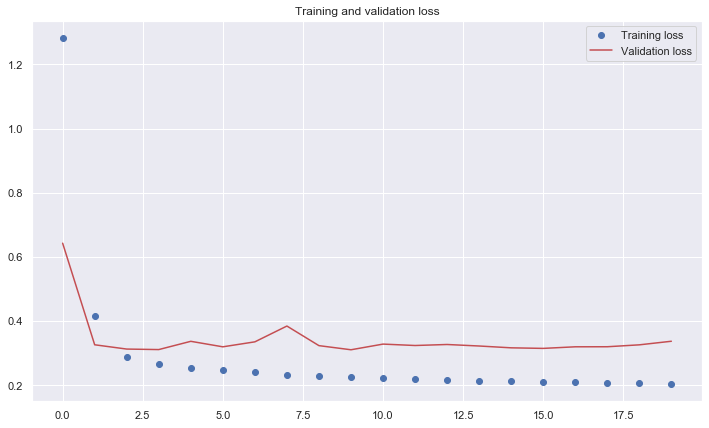

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

In [18]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [19]:
model.compile(optimizer=RMSprop(), loss='mae')

In [20]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0818 14:20:15.223967 11744 deprecation.py:323] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
500/500 [==============================] - 164s 327ms/step - loss: 0.3028 - val_loss: 0.2697
Epoch 2/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2831 - val_loss: 0.2681
Epoch 3/20
500/500 [==============================] - 162s 323ms/step - loss: 0.2795 - val_loss: 0.2678
Epoch 4/20
500/500 [==============================] - 162s 324ms/step - loss: 0.2699 - val_loss: 0.2651
Epoch 5/20
500/500 [==============================] - 160s 321ms/step - loss: 0.2668 - val_loss: 0.2804
Epoch 6/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2623 - val_loss: 0.2671
Epoch 7/20
500/500 [==============================] - 158s 317ms/step - loss: 0.2577 - val_loss: 0.2650
Epoch 8/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2548 - val_loss: 0.2697
Epoch 9/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2530 - val_loss: 0.2776
Epoch 10/20
500/500 [==============================] - 161s 323m

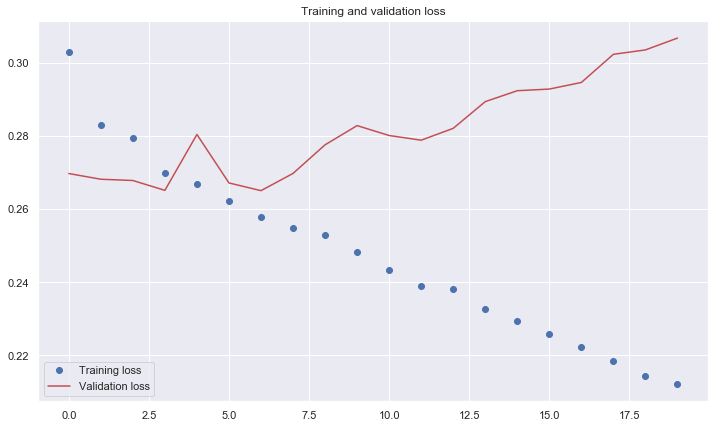

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

In [23]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

W0818 16:09:59.645497 11744 deprecation.py:506] From C:\Users\serge\Anaconda3\envs\KerasEnv\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [24]:
model.compile(optimizer=RMSprop(), loss='mae')

In [25]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 184s 368ms/step - loss: 0.3393 - val_loss: 0.2768
Epoch 2/40
500/500 [==============================] - 180s 360ms/step - loss: 0.3145 - val_loss: 0.2707
Epoch 3/40
500/500 [==============================] - 180s 361ms/step - loss: 0.3089 - val_loss: 0.2708
Epoch 4/40
500/500 [==============================] - 180s 361ms/step - loss: 0.3053 - val_loss: 0.2703
Epoch 5/40
500/500 [==============================] - 175s 351ms/step - loss: 0.3019 - val_loss: 0.2726
Epoch 6/40
500/500 [==============================] - 176s 352ms/step - loss: 0.2982 - val_loss: 0.2650
Epoch 7/40
500/500 [==============================] - 177s 353ms/step - loss: 0.2958 - val_loss: 0.2652
Epoch 8/40
500/500 [==============================] - 171s 341ms/step - loss: 0.2957 - val_loss: 0.2655
Epoch 9/40
500/500 [==============================] - 178s 355ms/step - loss: 0.2922 - val_loss: 0.2667
Epoch 10/40
500/500 [==============================] - 176s 353m

KeyboardInterrupt: 

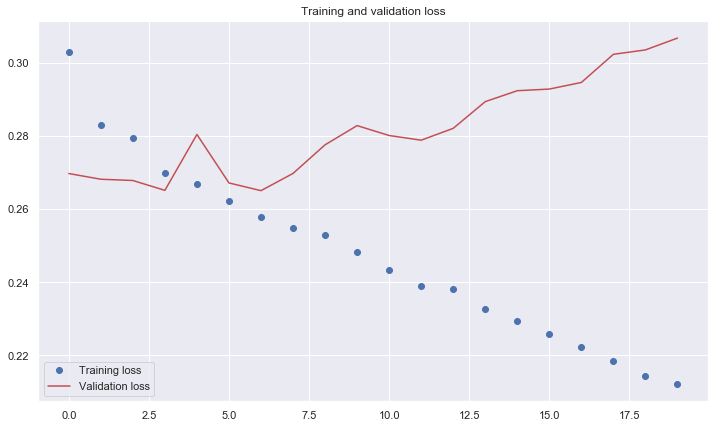

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

In [31]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [32]:
model.compile(optimizer=RMSprop(), loss='mae')

In [33]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 375s 750ms/step - loss: 0.3349 - val_loss: 0.2809
Epoch 2/40
500/500 [==============================] - 365s 730ms/step - loss: 0.3143 - val_loss: 0.2757
Epoch 3/40
500/500 [==============================] - 375s 751ms/step - loss: 0.3056 - val_loss: 0.2838
Epoch 4/40
500/500 [==============================] - 379s 758ms/step - loss: 0.3013 - val_loss: 0.2686
Epoch 5/40
500/500 [==============================] - 377s 754ms/step - loss: 0.2986 - val_loss: 0.2737
Epoch 6/40
500/500 [==============================] - 359s 718ms/step - loss: 0.2956 - val_loss: 0.2697
Epoch 7/40
500/500 [==============================] - 371s 742ms/step - loss: 0.2909 - val_loss: 0.2652
Epoch 8/40
500/500 [==============================] - 366s 731ms/step - loss: 0.2903 - val_loss: 0.2658
Epoch 9/40
500/500 [==============================] - 369s 738ms/step - loss: 0.2855 - val_loss: 0.2644
Epoch 10/40
500/500 [==============================] - 363s 726m

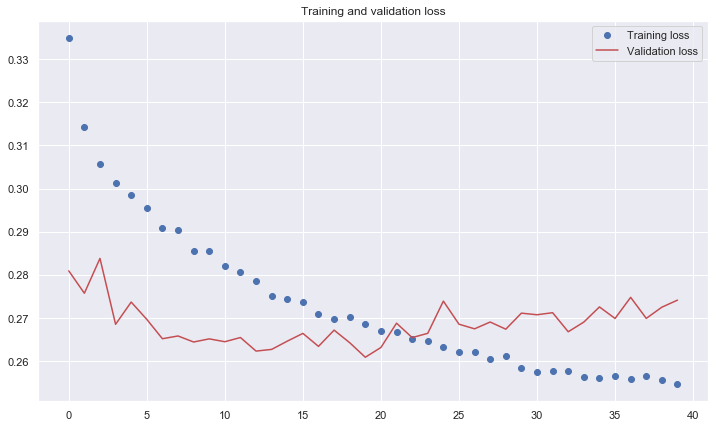

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,7))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

In [3]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1]))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

SyntaxError: invalid syntax (<ipython-input-3-094fee10c3f5>, line 3)

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
# history = model.fit_generator(train_gen,
#                               steps_per_epoch=500,
#                               epochs=40,
#                               validation_data=val_gen,
#                               validation_steps=val_steps)

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(loss))

# plt.figure(figsize=(12,7))

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend();